# Malone's Cones Business Plan Feasibility Study

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from haversine import haversine, Unit
from difflib import get_close_matches
from sqlalchemy import create_engine

## Background
Malone’s Cones is an ice cream distributor operating in Scranton, PA. The company owns a network of ice cream carts positioned throughout the city in areas of high pedestrian traffic. The company would like to expand into the Manhattan market and is requesting a market study to assess the feasibility of this plan. The company wants to position carts outside NYC subway stations during periods of high pedestrian traffic. The company wishes to avoid placing carts in the vicinity of a brick-and-mortar ice cream store. For a deliverable, the company wants charts showing rider counts for weekdays and weekends for stations with high foot traffic as well as lists of ice cream store competitors located near those stations.

## Processing turnstile data
* Download turnstile data for May - September 2019 from the MTA website. 
* Import the database into Python using SQLAlchemy.

In [2]:
engine = create_engine('sqlite:///mta_data.db')

In [3]:
turnstiles_df = pd.read_sql('SELECT * FROM mta_data', engine)

In [5]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,00:00:00,REGULAR,7206966,2441290
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,04:00:00,REGULAR,7206983,2441292
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,08:00:00,REGULAR,7207003,2441323
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,12:00:00,REGULAR,7207073,2441395
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,16:00:00,REGULAR,7207260,2441450


## Data cleaning

In [6]:
# Remove extra white spaces in column names
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]

In [7]:
turnstiles_df['DATE_TIME'] = pd.to_datetime(turnstiles_df.DATE + ' ' + turnstiles_df.TIME)

In [8]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE_TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,00:00:00,REGULAR,7206966,2441290,2019-09-21 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,04:00:00,REGULAR,7206983,2441292,2019-09-21 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,08:00:00,REGULAR,7207003,2441323,2019-09-21 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,12:00:00,REGULAR,7207073,2441395,2019-09-21 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/21/2019,16:00:00,REGULAR,7207260,2441450,2019-09-21 16:00:00


In [9]:
# Delete any duplicate rows using the column names we care about.
original_num_rows = turnstiles_df.shape[0]
turnstiles_df.drop_duplicates(subset = ["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)
cleaned_num_rows = turnstiles_df.shape[0]

print(f'{original_num_rows-cleaned_num_rows} rows were removed')

60 rows were removed


Remove columns with data we don't care about.

In [10]:
turnstiles_df.drop(['LINENAME', 'DIVISION', 'DESC'], axis=1, inplace=True)

Let's get a sense of which stations have the most foot traffic.

In [11]:
# Remove LINENAME, DIVISION, DESC, and EXITS columns because they are not relevant for this project.
turnstiles_daily = turnstiles_df[["C/A", "UNIT", "SCP", "STATION", "DATE", "TIME", "DATE_TIME", "ENTRIES", "EXITS"]]

Since ENTRIES is cumulative, we only care about the data at the end of the day. Therefore we need to sort data in descending order.

In [12]:
turnstiles_daily.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE", "TIME", "DATE_TIME"], axis=0, ascending=False, inplace=True)

In [13]:
turnstiles_daily.tail(20)

,C/A,UNIT,SCP,STATION,DATE,TIME,DATE_TIME,ENTRIES,EXITS
4330215,A002,R051,02-00-00,59 ST,04/30/2019,04:00:00,2019-04-30 04:00:00,7038261,2385769
4330214,A002,R051,02-00-00,59 ST,04/30/2019,00:00:00,2019-04-30 00:00:00,7038242,2385765
4330213,A002,R051,02-00-00,59 ST,04/29/2019,20:00:00,2019-04-29 20:00:00,7038042,2385732
4330212,A002,R051,02-00-00,59 ST,04/29/2019,16:00:00,2019-04-29 16:00:00,7037250,2385661
4330211,A002,R051,02-00-00,59 ST,04/29/2019,12:00:00,2019-04-29 12:00:00,7036956,2385602
4330210,A002,R051,02-00-00,59 ST,04/29/2019,08:00:00,2019-04-29 08:00:00,7036789,2385385
4330209,A002,R051,02-00-00,59 ST,04/29/2019,04:00:00,2019-04-29 04:00:00,7036754,2385260
4330208,A002,R051,02-00-00,59 ST,04/29/2019,00:00:00,2019-04-29 00:00:00,7036746,2385256
4330207,A002,R051,02-00-00,59 ST,04/28/2019,20:00:00,2019-04-28 20:00:00,7036621,2385240
4330206,A002,R051,02-00-00,59 ST,04/28/2019,16:00:00,2019-04-28 16:00:00,7036372,2385198


In [14]:
turnstiles_daily = turnstiles_daily.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"], as_index=False).ENTRIES.first()
turnstiles_daily

,C/A,UNIT,SCP,STATION,DATE,ENTRIES
0,A002,R051,02-00-00,59 ST,04/27/2019,7035930
1,A002,R051,02-00-00,59 ST,04/28/2019,7036621
2,A002,R051,02-00-00,59 ST,04/29/2019,7038042
3,A002,R051,02-00-00,59 ST,04/30/2019,7039520
4,A002,R051,02-00-00,59 ST,05/01/2019,7041075
...,...,...,...,...,...,...
749551,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/23/2019,5554
749552,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/24/2019,5554
749553,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/25/2019,5554
749554,TRAM2,R469,00-05-01,RIT-ROOSEVELT,09/26/2019,5554


Now we will calculate the number of daily entries but subtracting rows of cumulative data. First we will create new columns with the previous day and entry data.

In [15]:
turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

<ipython-input-15-3a945374269e>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  turnstiles_daily[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily


In [16]:
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
0,A002,R051,02-00-00,59 ST,04/27/2019,7035930,NaN,NaN
1,A002,R051,02-00-00,59 ST,04/28/2019,7036621,04/27/2019,7035930.0
2,A002,R051,02-00-00,59 ST,04/29/2019,7038042,04/28/2019,7036621.0
3,A002,R051,02-00-00,59 ST,04/30/2019,7039520,04/29/2019,7038042.0
4,A002,R051,02-00-00,59 ST,05/01/2019,7041075,04/30/2019,7039520.0


In [17]:
# Drop the rows for the earliest dates in the df
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

As shown below, some stations have cumulative counters that appear to be going backwards. This is because some counters need resetting. We will do that with a custom function.

In [18]:
turnstiles_daily[turnstiles_daily["ENTRIES"] < turnstiles_daily["PREV_ENTRIES"]]

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,PREV_DATE,PREV_ENTRIES
1767,A002,R051,02-06-00,59 ST,07/13/2019,524,07/12/2019,2.582490e+05
3326,A007,R079,01-05-01,5 AV/59 ST,08/05/2019,0,08/04/2019,1.000000e+00
5973,A011,R080,01-03-00,57 ST-7 AV,08/20/2019,885829427,08/19/2019,8.858297e+08
5974,A011,R080,01-03-00,57 ST-7 AV,08/21/2019,885828919,08/20/2019,8.858294e+08
5975,A011,R080,01-03-00,57 ST-7 AV,08/22/2019,885828367,08/21/2019,8.858289e+08
...,...,...,...,...,...,...,...,...
742936,R730,R431,00-00-04,EASTCHSTER/DYRE,09/24/2019,1559928704,09/23/2019,1.559929e+09
742937,R730,R431,00-00-04,EASTCHSTER/DYRE,09/25/2019,1559928105,09/24/2019,1.559929e+09
742938,R730,R431,00-00-04,EASTCHSTER/DYRE,09/26/2019,1559927505,09/25/2019,1.559928e+09
742939,R730,R431,00-00-04,EASTCHSTER/DYRE,09/27/2019,1559926930,09/26/2019,1.559928e+09


In [19]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
#         print(row["ENTRIES"], row["PREV_ENTRIES"])
        return 0
    return counter

In [20]:
def get_daily_counts_exits(row, max_counter):
    counter = row["EXITS"] - row["PREV_EXITS"]
    if counter < 0:
        counter = -counter
    if counter > max_counter:
#         print(row["ENTRIES"], row["PREV_ENTRIES"])
        return 0
    return counter

In [21]:
turnstiles_daily["DAILY_ENTRIES"] = turnstiles_daily.apply(get_daily_counts, axis=1, max_counter=1000000)

Drop rows containing NaN. These are rows which are at the beginning of a count so the number of riders is 0.

In [22]:
turnstiles_daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

Drop the PREV_DATE and PREV_ENTRIES because we no longer need them.

In [23]:
turnstiles_daily.drop(['PREV_DATE', 'PREV_ENTRIES'], axis=1, inplace=True, errors='ignore')
turnstiles_daily.head()

,C/A,UNIT,SCP,STATION,DATE,ENTRIES,DAILY_ENTRIES
1,A002,R051,02-00-00,59 ST,04/28/2019,7036621,691.0
2,A002,R051,02-00-00,59 ST,04/29/2019,7038042,1421.0
3,A002,R051,02-00-00,59 ST,04/30/2019,7039520,1478.0
4,A002,R051,02-00-00,59 ST,05/01/2019,7041075,1555.0
5,A002,R051,02-00-00,59 ST,05/02/2019,7042630,1555.0


In [24]:
turnstiles_daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 744593 entries, 1 to 749555
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   C/A            744593 non-null  object 
 1   UNIT           744593 non-null  object 
 2   SCP            744593 non-null  object 
 3   STATION        744593 non-null  object 
 4   DATE           744593 non-null  object 
 5   ENTRIES        744593 non-null  int64  
 6   DAILY_ENTRIES  744593 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 45.4+ MB


Now we need to sum data across each turnstile for each station because we don't care about the breakdown of numbers among turnstiles.

In [25]:
stations_daily = turnstiles_daily.groupby(['STATION', 'DATE']).DAILY_ENTRIES.sum().reset_index()
stations_daily.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,04/28/2019,5205.0
1,1 AV,04/29/2019,17134.0
2,1 AV,04/30/2019,18588.0
3,1 AV,05/01/2019,19221.0
4,1 AV,05/02/2019,19406.0


In [26]:
stations_daily.DATE = pd.to_datetime(stations_daily.DATE)

In [27]:
stations_daily['MONTH'] = stations_daily.DATE.dt.month

In [28]:
stations_daily = stations_daily.groupby(['STATION', 'MONTH']).DAILY_ENTRIES.mean().sort_values(ascending=False).reset_index()

In [29]:
stations_daily = stations_daily[(stations_daily.MONTH >= 5) & (stations_daily.MONTH <= 9)].groupby('STATION').DAILY_ENTRIES.mean().sort_values(ascending=False)
stations_daily = stations_daily.reset_index()

In [30]:
stations_daily

,STATION,DAILY_ENTRIES
0,34 ST-PENN STA,147711.243943
1,GRD CNTRL-42 ST,145846.210251
2,34 ST-HERALD SQ,112253.648435
3,23 ST,107763.905066
4,TIMES SQ-42 ST,96155.798949
...,...,...
373,TOMPKINSVILLE,610.130777
374,BEACH 98 ST,607.809080
375,BEACH 105 ST,359.580932
376,BROAD CHANNEL,280.086714


Text(0.5, 1.0, 'Average daily riders for MTA subway (sorted)')

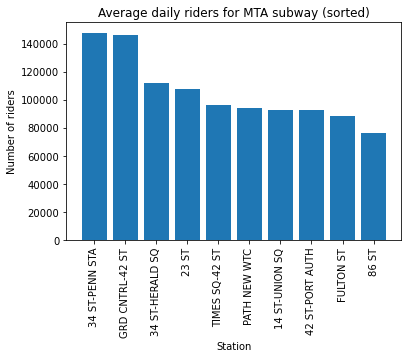

In [31]:
# sns.barplot(data=stations_daily, x=stations_daily.index)
plt.bar(x=stations_daily['STATION'][:10], height=stations_daily['DAILY_ENTRIES'][:10])
plt.xticks(rotation=90)
plt.xlabel('Station')
plt.ylabel('Number of riders')
plt.title('Average daily riders for MTA subway (sorted)')

From the above list, we will choose a few stations that have high foot traffic and generate charts showing the average number of riders for each time of day for weekdays and weekends. We will hard-code in station names from and GPS coordinates from Google Maps. For example, the station closest to Times Square is 'TIMES SQ-42 ST' so that's what we'll work with to start.

In [32]:
# Reset stations_daily for downstream code.
stations_daily = turnstiles_daily.groupby(['STATION', 'DATE']).DAILY_ENTRIES.sum().reset_index()

In [33]:
# Generate a list of unique stations
list_of_stations = stations_daily.STATION.unique()
list_of_stations

array(['1 AV', '103 ST', '103 ST-CORONA', '104 ST', '110 ST', '111 ST',
       '116 ST', '116 ST-COLUMBIA', '121 ST', '125 ST', '135 ST',
       '137 ST CITY COL', '138/GRAND CONC', '14 ST', '14 ST-UNION SQ',
       '145 ST', '149/GRAND CONC', '14TH STREET', '15 ST-PROSPECT',
       '155 ST', '157 ST', '161/YANKEE STAD', '163 ST-AMSTERDM', '167 ST',
       '168 ST', '169 ST', '170 ST', '174 ST', '174-175 STS', '175 ST',
       '176 ST', '18 AV', '18 ST', '181 ST', '182-183 STS', '183 ST',
       '190 ST', '191 ST', '2 AV', '20 AV', '207 ST', '21 ST',
       '21 ST-QNSBRIDGE', '215 ST', '219 ST', '225 ST', '23 ST', '231 ST',
       '233 ST', '238 ST', '25 AV', '25 ST', '28 ST', '3 AV',
       '3 AV 138 ST', '3 AV-149 ST', '30 AV', '33 ST', '33 ST-RAWSON ST',
       '34 ST-HERALD SQ', '34 ST-HUDSON YD', '34 ST-PENN STA', '36 AV',
       '36 ST', '39 AV', '4 AV-9 ST', '40 ST LOWERY ST',
       '42 ST-BRYANT PK', '42 ST-PORT AUTH', '45 ST', '46 ST',
       '46 ST BLISS ST', '47-50 STS ROCK

In [34]:
# Using Google Maps, pick names of stations, search for them in the 
# list of station names to find the ones closest to Times Square.

# get_close_matches('50 ST', list_of_stations)

# All code below will generate entry data barplots and a list of ice cream stores within 1/3 of a mile.

In [604]:
station_details = ('207 ST', 40.86757246258775, -73.92086459277627)
month_number = 7
month_name = 'July'
max_distance = 0.333
year = 2019

In [605]:
station = station_details[0]

In [606]:
subway_loc = station_details[1:]
subway_loc

(40.86757246258775, -73.92086459277627)

In [607]:
turnstiles_station = stations_daily[stations_daily.STATION == station]

In [608]:
turnstiles_station

,STATION,DATE,DAILY_ENTRIES
6117,207 ST,04/28/2019,2427.0
6118,207 ST,04/29/2019,6088.0
6119,207 ST,04/30/2019,6304.0
6120,207 ST,05/01/2019,6600.0
6121,207 ST,05/02/2019,6534.0
...,...,...,...
6265,207 ST,09/23/2019,6210.0
6266,207 ST,09/24/2019,6523.0
6267,207 ST,09/25/2019,6670.0
6268,207 ST,09/26/2019,6461.0


In [609]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline 

<AxesSubplot:>

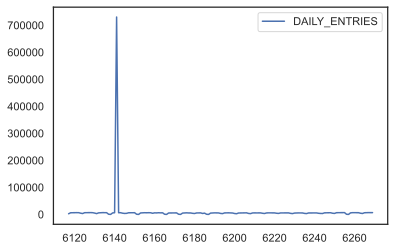

In [610]:
sns.set_style("white")
sns.lineplot(data=turnstiles_station)

In [611]:
# Remove outlier values. Then replot.
turnstiles_station = turnstiles_station[turnstiles_station.DAILY_ENTRIES < 200000].copy()
turnstiles_station

,STATION,DATE,DAILY_ENTRIES
6117,207 ST,04/28/2019,2427.0
6118,207 ST,04/29/2019,6088.0
6119,207 ST,04/30/2019,6304.0
6120,207 ST,05/01/2019,6600.0
6121,207 ST,05/02/2019,6534.0
...,...,...,...
6265,207 ST,09/23/2019,6210.0
6266,207 ST,09/24/2019,6523.0
6267,207 ST,09/25/2019,6670.0
6268,207 ST,09/26/2019,6461.0


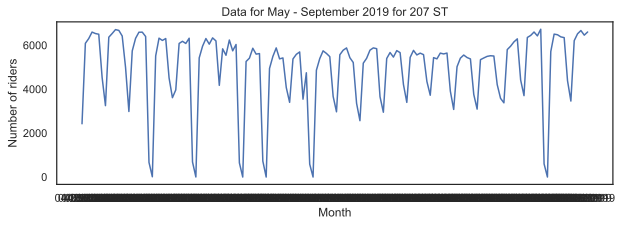

In [612]:
plt.figure(figsize=(10,3))
sns.lineplot(data=turnstiles_station, x='DATE', y='DAILY_ENTRIES')
# plt.annotate('All months', xy=(0.5, .8), xycoords='axes fraction', fontsize=15)
plt.title('Data for May - September 2019 for ' + station)
plt.xlabel('Month')
plt.ylabel('Number of riders')
plt.savefig('Figures/' + station)

As you can see, ridership is cyclical. There are more riders during weekdays and fewer riders on weekends.

In [613]:
turnstiles_station['DATE'] = pd.to_datetime(turnstiles_station.DATE)
turnstiles_station['MONTH'] = turnstiles_station.DATE.dt.month
turnstiles_station.head()

,STATION,DATE,DAILY_ENTRIES,MONTH
6117,207 ST,2019-04-28,2427.0,4
6118,207 ST,2019-04-29,6088.0,4
6119,207 ST,2019-04-30,6304.0,4
6120,207 ST,2019-05-01,6600.0,5
6121,207 ST,2019-05-02,6534.0,5


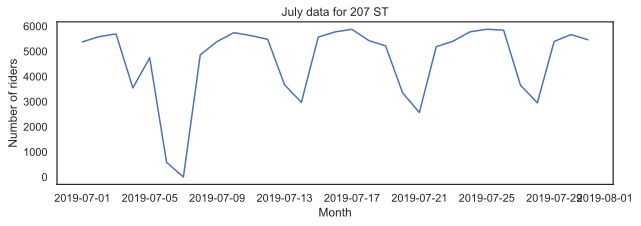

In [614]:
# Let's look at a single month so the data are not so cramped.
plt.figure(figsize=(10,3))
sns.lineplot(data=turnstiles_station.query('MONTH == ' + str(month_number)), x='DATE', y='DAILY_ENTRIES')
# plt.annotate('June', xy=(0.4, 0.2), xycoords='axes fraction', fontsize=15)
plt.xlabel('Month')
plt.ylabel('Number of riders')
plt.title('July data for ' + station)
plt.savefig('Figures/' + month_name + ' data for ' + station)

There is a dip in ridership in early July, probably related to July 4th weekend.

Now we will process the data to generate average riders per weekday and weekend as a function of time.

In [615]:
turnstiles_times = turnstiles_df.copy()

In [616]:
# Since we know what month and station we want, we will slice the data set 
# so it will be smaller and our code will run faster
turnstiles_times = turnstiles_times[turnstiles_times.STATION == station]

In [617]:
turnstiles_times['MONTH'] = turnstiles_times.DATE_TIME.dt.month

In [618]:
turnstiles_times = turnstiles_times[turnstiles_times.MONTH == month_number].copy()

In [619]:
turnstiles_times

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,MONTH
1795240,R188,R037,00-00-00,207 ST,07/27/2019,00:00:00,9914071,2161786,2019-07-27 00:00:00,7
1795241,R188,R037,00-00-00,207 ST,07/27/2019,04:00:00,9914090,2161793,2019-07-27 04:00:00,7
1795242,R188,R037,00-00-00,207 ST,07/27/2019,08:00:00,9914168,2161850,2019-07-27 08:00:00,7
1795243,R188,R037,00-00-00,207 ST,07/27/2019,12:00:00,9914366,2162008,2019-07-27 12:00:00,7
1795244,R188,R037,00-00-00,207 ST,07/27/2019,16:00:00,9914608,2162132,2019-07-27 16:00:00,7
...,...,...,...,...,...,...,...,...,...,...
2627725,R188,R037,00-06-02,207 ST,07/05/2019,04:00:00,88340,131403,2019-07-05 04:00:00,7
2627726,R188,R037,00-06-02,207 ST,07/05/2019,08:00:00,88371,131438,2019-07-05 08:00:00,7
2627727,R188,R037,00-06-02,207 ST,07/05/2019,12:00:00,88428,131502,2019-07-05 12:00:00,7
2627728,R188,R037,00-06-02,207 ST,07/05/2019,16:00:00,88496,131587,2019-07-05 16:00:00,7


In [620]:
# Create a function to convert the datetime time to float because that will make binning the times easier. 
# More detailed explanation is a few lines down.

def dt_to_float(time):
    time=str(time)
    time = pd.to_datetime(time)
    hours = time.hour
    minutes = time.minute
    return hours + minutes/60

In [621]:
turnstiles_times.TIME = turnstiles_times.TIME.apply(dt_to_float)

In [622]:
turnstiles_times

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,MONTH
1795240,R188,R037,00-00-00,207 ST,07/27/2019,0.0,9914071,2161786,2019-07-27 00:00:00,7
1795241,R188,R037,00-00-00,207 ST,07/27/2019,4.0,9914090,2161793,2019-07-27 04:00:00,7
1795242,R188,R037,00-00-00,207 ST,07/27/2019,8.0,9914168,2161850,2019-07-27 08:00:00,7
1795243,R188,R037,00-00-00,207 ST,07/27/2019,12.0,9914366,2162008,2019-07-27 12:00:00,7
1795244,R188,R037,00-00-00,207 ST,07/27/2019,16.0,9914608,2162132,2019-07-27 16:00:00,7
...,...,...,...,...,...,...,...,...,...,...
2627725,R188,R037,00-06-02,207 ST,07/05/2019,4.0,88340,131403,2019-07-05 04:00:00,7
2627726,R188,R037,00-06-02,207 ST,07/05/2019,8.0,88371,131438,2019-07-05 08:00:00,7
2627727,R188,R037,00-06-02,207 ST,07/05/2019,12.0,88428,131502,2019-07-05 12:00:00,7
2627728,R188,R037,00-06-02,207 ST,07/05/2019,16.0,88496,131587,2019-07-05 16:00:00,7


In [623]:
turnstiles_times["PREV_ENTRIES"] = (turnstiles_times
                                                       .groupby(["STATION"])["ENTRIES"]
                                                       .apply(lambda grp: grp.shift(1)))

In [624]:
turnstiles_times["PREV_EXITS"] = (turnstiles_times
                                                       .groupby(["STATION"])["EXITS"]
                                                       .apply(lambda grp: grp.shift(1)))

For the below "get_daily_counts" function, setting the max-counter to a low value is critical because there are lots of turnstiles with an impossibly large number of people passing through them per day. It's not likely 10,000 people will pass through a single turnstile in one day. Setting the max_counter too high means we don't reset the rider count often enough which generates impossibly large rider counts for each station (in the millions per day).

In [625]:
turnstiles_times["DAILY_ENTRIES"] = turnstiles_times.apply(get_daily_counts, axis=1, max_counter=2100)

In [626]:
turnstiles_times["DAILY_EXITS"] = turnstiles_times.apply(get_daily_counts_exits, axis=1, max_counter=2100)

In [627]:
turnstiles_times

,C/A,UNIT,SCP,STATION,DATE,TIME,ENTRIES,EXITS,DATE_TIME,MONTH,PREV_ENTRIES,PREV_EXITS,DAILY_ENTRIES,DAILY_EXITS
1795240,R188,R037,00-00-00,207 ST,07/27/2019,0.0,9914071,2161786,2019-07-27 00:00:00,7,NaN,NaN,NaN,NaN
1795241,R188,R037,00-00-00,207 ST,07/27/2019,4.0,9914090,2161793,2019-07-27 04:00:00,7,9914071.0,2161786.0,19.0,7.0
1795242,R188,R037,00-00-00,207 ST,07/27/2019,8.0,9914168,2161850,2019-07-27 08:00:00,7,9914090.0,2161793.0,78.0,57.0
1795243,R188,R037,00-00-00,207 ST,07/27/2019,12.0,9914366,2162008,2019-07-27 12:00:00,7,9914168.0,2161850.0,198.0,158.0
1795244,R188,R037,00-00-00,207 ST,07/27/2019,16.0,9914608,2162132,2019-07-27 16:00:00,7,9914366.0,2162008.0,242.0,124.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2627725,R188,R037,00-06-02,207 ST,07/05/2019,4.0,88340,131403,2019-07-05 04:00:00,7,88334.0,131377.0,6.0,26.0
2627726,R188,R037,00-06-02,207 ST,07/05/2019,8.0,88371,131438,2019-07-05 08:00:00,7,88340.0,131403.0,31.0,35.0
2627727,R188,R037,00-06-02,207 ST,07/05/2019,12.0,88428,131502,2019-07-05 12:00:00,7,88371.0,131438.0,57.0,64.0
2627728,R188,R037,00-06-02,207 ST,07/05/2019,16.0,88496,131587,2019-07-05 16:00:00,7,88428.0,131502.0,68.0,85.0


In [628]:
turnstiles_times['DAY'] = turnstiles_times.DATE_TIME.dt.day

Below is an example of a typical rider count for a typical day. As you can see in the chart above with all the station daily totals, the number does not rise above  150,000 for the busiest stations so we set our max_counter such that a typical daily count does not exceed 150,000.

In [629]:

turnstiles_times[turnstiles_times.DAY==2].DAILY_ENTRIES.sum()

5586.0

## Binning data
Now we will bin the data. There are times that do not neatly fit into 4-hour blocks so we will round up all the times to the nearest 4-hour block from midnight to 8 pm. There will be some error because some blocks of time that belong to an earlier bin will be included in a later bin but the number of riders with non-standard time blocks is small compared to the times with standard time blocks. Rounding will not completely provide a numerically exact answer but will improve the data. The improvement will be enough to answer our business question so we will not attempt to generate a more exact answer.

In [630]:
# Bins set to capture data up to 8 pm (20:00). 
# It starts at -1 to capture the midnight data which includes counts from 8 pm the previous day.
turnstiles_times['range'] = pd.cut(turnstiles_times.TIME, bins = [-1, 0, 4, 8, 12, 16, 20], include_lowest=False, labels=['8 PM - Midnight', 'Midnight - 4 AM', '4 - 8 AM', '8 - 12 PM', '12 PM - 4 PM', '4 PM - 8 PM'])
# turnstiles_times['range'] = pd.cut(turnstiles_times.TIME, bins = [-1, 0, 4, 8, 12, 16, 20, 24], include_lowest=False, labels=['8 PM - Midnight', 'Midnight - 4 AM', '4 - 8 AM', '8 - 12 PM', '12 PM - 4 PM', '4 PM - 8 PM', '8 PM - Midnight '])

In [631]:
turnstiles_times.drop(['TIME', 'MONTH'], axis=1, inplace=True)

In [632]:
turnstiles_times.drop(['DATE','ENTRIES','DATE_TIME','PREV_ENTRIES', 'EXITS', 'PREV_EXITS'], axis=1)

,C/A,UNIT,SCP,STATION,DAILY_ENTRIES,DAILY_EXITS,DAY,range
1795240,R188,R037,00-00-00,207 ST,NaN,NaN,27,8 PM - Midnight
1795241,R188,R037,00-00-00,207 ST,19.0,7.0,27,Midnight - 4 AM
1795242,R188,R037,00-00-00,207 ST,78.0,57.0,27,4 - 8 AM
1795243,R188,R037,00-00-00,207 ST,198.0,158.0,27,8 - 12 PM
1795244,R188,R037,00-00-00,207 ST,242.0,124.0,27,12 PM - 4 PM
...,...,...,...,...,...,...,...,...
2627725,R188,R037,00-06-02,207 ST,6.0,26.0,5,Midnight - 4 AM
2627726,R188,R037,00-06-02,207 ST,31.0,35.0,5,4 - 8 AM
2627727,R188,R037,00-06-02,207 ST,57.0,64.0,5,8 - 12 PM
2627728,R188,R037,00-06-02,207 ST,68.0,85.0,5,12 PM - 4 PM


In [633]:
turnstiles_times.groupby(['DAY','range'])[['DAILY_ENTRIES', 'DAILY_EXITS']].sum().reset_index()

,DAY,range,DAILY_ENTRIES,DAILY_EXITS
0,1,8 PM - Midnight,0.0,0.0
1,1,Midnight - 4 AM,92.0,82.0
2,1,4 - 8 AM,1013.0,255.0
3,1,8 - 12 PM,1339.0,485.0
4,1,12 PM - 4 PM,1171.0,630.0
...,...,...,...,...
181,31,Midnight - 4 AM,82.0,117.0
182,31,4 - 8 AM,1054.0,298.0
183,31,8 - 12 PM,1454.0,495.0
184,31,12 PM - 4 PM,1175.0,678.0


In [634]:
# Add all the daily counts across each turnstile.
turnstiles_times = turnstiles_times.groupby(['DAY','range'])[['DAILY_ENTRIES', 'DAILY_EXITS']].sum().reset_index()
turnstiles_times

,DAY,range,DAILY_ENTRIES,DAILY_EXITS
0,1,8 PM - Midnight,0.0,0.0
1,1,Midnight - 4 AM,92.0,82.0
2,1,4 - 8 AM,1013.0,255.0
3,1,8 - 12 PM,1339.0,485.0
4,1,12 PM - 4 PM,1171.0,630.0
...,...,...,...,...
181,31,Midnight - 4 AM,82.0,117.0
182,31,4 - 8 AM,1054.0,298.0
183,31,8 - 12 PM,1454.0,495.0
184,31,12 PM - 4 PM,1175.0,678.0


In [635]:
# def week_or_weekend(day):
#     if day == 5 or day == 6: return 'weekend'
#     else: return 'weekday'

In [636]:
# Since we want to examine data as a function of whether it is a weekday or weekend, let's create a function
# that indicates whether the day in question is a weekday or weekend.
def week_or_weekend(day_num):
    date = str(month_number) + '/' + str(day_num) + '/' + str(year)
    date = pd.to_datetime(date)
    date = int(date.day_of_week)
    if date == 5 or date == 6: 
        return 'weekend'
    return 'weekday'



In [637]:
turnstiles_times['WW'] = turnstiles_times.DAY.apply(week_or_weekend)

In [638]:
turnstiles_times.groupby(['WW', 'range'])[['DAILY_ENTRIES', 'DAILY_EXITS']].mean().reset_index()

,WW,range,DAILY_ENTRIES,DAILY_EXITS
0,weekday,8 PM - Midnight,481.521739,386.782609
1,weekday,Midnight - 4 AM,95.130435,88.782609
2,weekday,4 - 8 AM,972.565217,284.652174
3,weekday,8 - 12 PM,1436.130435,509.782609
4,weekday,12 PM - 4 PM,1178.826087,666.000000
5,weekday,4 PM - 8 PM,1230.217391,864.956522
6,weekend,8 PM - Midnight,212.500000,129.500000
7,weekend,Midnight - 4 AM,111.625000,60.625000
8,weekend,4 - 8 AM,184.125000,130.625000
9,weekend,8 - 12 PM,443.375000,415.000000


In [639]:
turnstiles_times_data = turnstiles_times.groupby(['WW', 'range'])[['DAILY_ENTRIES', 'DAILY_EXITS']].mean().reset_index()

In [640]:
turnstiles_times_data

,WW,range,DAILY_ENTRIES,DAILY_EXITS
0,weekday,8 PM - Midnight,481.521739,386.782609
1,weekday,Midnight - 4 AM,95.130435,88.782609
2,weekday,4 - 8 AM,972.565217,284.652174
3,weekday,8 - 12 PM,1436.130435,509.782609
4,weekday,12 PM - 4 PM,1178.826087,666.000000
5,weekday,4 PM - 8 PM,1230.217391,864.956522
6,weekend,8 PM - Midnight,212.500000,129.500000
7,weekend,Midnight - 4 AM,111.625000,60.625000
8,weekend,4 - 8 AM,184.125000,130.625000
9,weekend,8 - 12 PM,443.375000,415.000000


## Plot data 

In [641]:
melted_df = pd.melt(turnstiles_times_data, id_vars=["WW", "range"], var_name="entry_exit", value_name="number")
melted_df

,WW,range,entry_exit,number
0,weekday,8 PM - Midnight,DAILY_ENTRIES,481.521739
1,weekday,Midnight - 4 AM,DAILY_ENTRIES,95.130435
2,weekday,4 - 8 AM,DAILY_ENTRIES,972.565217
3,weekday,8 - 12 PM,DAILY_ENTRIES,1436.130435
4,weekday,12 PM - 4 PM,DAILY_ENTRIES,1178.826087
5,weekday,4 PM - 8 PM,DAILY_ENTRIES,1230.217391
6,weekend,8 PM - Midnight,DAILY_ENTRIES,212.500000
7,weekend,Midnight - 4 AM,DAILY_ENTRIES,111.625000
8,weekend,4 - 8 AM,DAILY_ENTRIES,184.125000
9,weekend,8 - 12 PM,DAILY_ENTRIES,443.375000


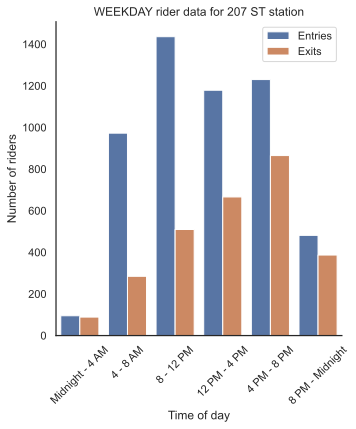

In [642]:
sns.set(rc={"figure.figsize":(9, 8)}, style='white') #width=9, height=8
sns.catplot(x='range', y='number', hue='entry_exit', data=melted_df[melted_df.WW == 'weekday'], kind='bar',
           order=['Midnight - 4 AM', '4 - 8 AM', '8 - 12 PM', '12 PM - 4 PM', '4 PM - 8 PM', '8 PM - Midnight'],
           legend_out=False)
plt.ylabel('Number of riders')
plt.xlabel('Time of day')
# plt.gca().set_ylim(0, 55000)
plt.xticks(rotation=45)
plt.title('WEEKDAY rider data for ' + station + ' station')

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h, ['Entries', 'Exits'], title="")

plt.savefig('Figures/' + 'rider_times_' + station + '_weekday', bbox_inches='tight')

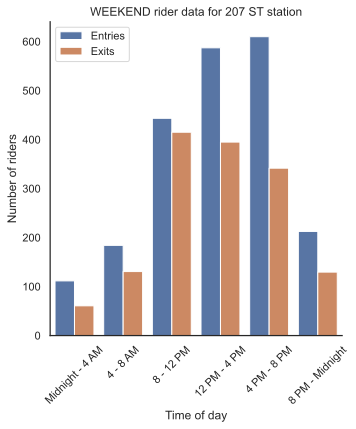

In [643]:
sns.set(rc={"figure.figsize":(9, 8)}, style='white') #width=9, height=8
sns.catplot(x='range', y='number', hue='entry_exit', data=melted_df[melted_df.WW == 'weekend'], kind='bar',
           order=['Midnight - 4 AM', '4 - 8 AM', '8 - 12 PM', '12 PM - 4 PM', '4 PM - 8 PM', '8 PM - Midnight'],
           legend_out=False)
plt.ylabel('Number of riders')
plt.xlabel('Time of day')
# plt.gca().set_ylim(0, 55000)
plt.xticks(rotation=45)
plt.title('WEEKEND rider data for ' + station + ' station')

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h, ['Entries', 'Exits'], title="")

plt.savefig('Figures/' + 'rider_times_' + station + '_weekend', bbox_inches='tight' )

In [644]:
# sns.set(rc={"figure.figsize":(9, 8)}, style='white') #width=9, height=8
# sns.barplot(data = turnstiles_times_data,
#             x='range', y='DAILY_ENTRIES', hue='WW', order=['Midnight - 4 AM', '4 - 8 AM', 
#                                                            '8 - 12 PM', '12 PM - 4 PM', '4 PM - 8 PM', 
#                                                            '8 PM - Midnight'])
# plt.ylabel('Number of riders')
# plt.xlabel('Time of day')
# # plt.gca().set_ylim(0, 55000)
# plt.xticks(rotation=45)
# plt.title(station)
# plt.gca().legend().set_title('')
# plt.savefig('Figures/' + 'rider_times_' + station )


## Ice cream stores
Lastly, we will import a list of ice cream stores and their geocoordinates downloaded from Google Maps using Phantombuster, a free webscraping tool.

In [645]:
df = pd.read_csv('ice_cream_store_locations.csv')

In [646]:
# Remove stores that are temporarily closed or are missing hours completely. These stores may no longer exist.
mask_df_hours = (df.currentStatus == 'Temporarily closed') | (df.currentStatus.isna())
df_open = df[~mask_df_hours]
list_of_open_stores = df_open[['title','latitude','longitude']].copy()
list_of_open_stores.dropna(inplace=True)

In [647]:
list_of_open_stores.head()

,title,latitude,longitude
1,Davey's Ice Cream,40.727937,-73.985312
2,Van Leeuwen Ice Cream,40.727687,-73.987687
3,Sedutto,40.771687,-73.952938
4,Surreal Creamery,40.742062,-73.977563
6,Mikey Likes It Ice Cream,40.729438,-73.981313


Picture from Google Earth of ice cream store locations scraped from Google Maps.

![title](google_earth_ice_cream_stores.jpg)

Now we will generate a list of all ice cream stores located with a radius we set at the top of this notebook of the station using the haversine equation.

In [648]:
stores_station = list_of_open_stores

# The haversine function calculates the distance between two points on a sphere.

def distance(row, lat2, long2):
    lat1 = row.latitude
    long1 = row.longitude
    
    return haversine((lat1, long1),(lat2, long2), unit=Unit.MILES)

In [649]:
stores_station['distance_to_subway'] = stores_station.apply(distance, axis=1, lat2 = subway_loc[0], long2 = subway_loc[1])

In [650]:
stores_station.head()

,title,latitude,longitude,distance_to_subway
1,Davey's Ice Cream,40.727937,-73.985312,10.219808
2,Van Leeuwen Ice Cream,40.727687,-73.987687,10.277698
3,Sedutto,40.771687,-73.952938,6.833981
4,Surreal Creamery,40.742062,-73.977563,9.164874
6,Mikey Likes It Ice Cream,40.729438,-73.981313,10.054273


Filter out ice cream stores within the necessary radius.

In [651]:
stores_station = stores_station[stores_station.distance_to_subway <= max_distance].set_index('title')

In [652]:
stores_station.distance_to_subway = stores_station.distance_to_subway.round(2)
stores_station.columns = ['latitude', 'longitude', 'distance_to_subway_(miles)']

In [653]:
stores_station.sort_values('distance_to_subway_(miles)', inplace=True)

In [654]:
# Export ice cream station results to a csv. Data are appended to existing data so we have a single sheet to work with.
stores_station.index.rename(station, inplace=True)
stores_station.to_csv('Figures/store_distances.csv', mode='a')
stores_station

,latitude,longitude,distance_to_subway_(miles)
207 ST,,,
